# Capstone Regression Project: *Concerning MLB Arbitration*

## Author: Dylan Beattie

## Business Understanding

Every year in Major League Baseball, players with between 3 and 6 years of service time (and in some cases, 2 years) and without a long-term contract undergo a process called salary arbitration. In this process, the player and team undergo negotiate to determine what the player's salary shall be for the following season. These salaries are largely based on the salaries of comparable players around the league. In some cases, the player and team cannot reach an agreement before the mid-January deadline and the two sides submit suggested salaries to a third party who then rule for one side or another.

Acting on behalf of a player agency, in the following analysis I will investigate this arbitration process on a statistical level. The purpose of this analysis is to find what most influences the salary that is settled on by the parties involved. To do this I will model the salaries using a multi-variable linear regression that will include player's age, service time, position, awards received, and general baseball statistics (batting average, home runs, RBI, etc.).

In addition to creating a model to best predict the settled arbitration numbers, I will also investigate whether or not the statistical features that most influence the model are the same as those that best correlate to winning. That is, are the factors that are most valued in salary negotiations actually the ones that help teams win the most?

## Data Understanding

Our data will come from two sources: 1) arbitration data compiled by the baseball blog [MLB Trade Rumors](https://mlbtraderumors.com) and 2) general baseaball statistics and biographical information compiled across multiple tables by journalist and baseball statistician Sean Lahman and hosted on [Baseball Archive](https://www.seanlahman.com/baseball-archive/).

Our arbitration data goes runs from 2011 through 2022 (and includes information on 2241 cases) but the Baseball Archive data is much more comprensive and runs from the 1870's the end of the 2021 season. The arbitration data provides data only on service time (how long the player has been in the league) and arbitration information (team settled with, settlement amount, etc.). The data provided in the databank includes all biographical player information, individual season-by-season statistics for each player, and team season-by-season statistics. 

A potential issue for this dataset is that the arbitration data from MLB Trade Rumors blog is much more informal than the Baseball Archive and will be potentially tricky to merge. For the Baseball Archive dataset, unique identifiers are provided for each player and team, while in the MLB Trade Rumors blog they are referred to by name only. Trying to join tables on non-unique keys will result in potential duplicates and we'll need to take additional steps to reduce the likelihood and impact of this happening.

## Data Preparation

### Loading and Cleaning the Data

First let's start by setting our plotting environment:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,8)})
#use following for printing plots for slide deck
sns.set(rc = {'figure.figsize':(11,6)})
TITLE_SIZE = 'x-large'
LABEL_SIZE = 'large'
X_TICKS = 14

We'll begin by downloading arbitration data compiled by the baseball blog [MLB Trade Rumors](https://mlbtraderumors.com). The data runs from 2011 through 2022 and will be imported season-by-season and concatenated as one single dataframe. Note that 2268 arbitration cases are included in the dataset.

In [2]:
import pandas as pd
import numpy as np

col_names = ['Player', 'Team', 'Service_Time', 'Player_Amount', 'Team_Amount', 'Midpoint', 'Settled_Amount', 'Year']
arbitration_data = pd.DataFrame(columns = col_names)

for year in range(2011,2023):
    file_name = 'mlb_data/arbitration/arb_{}.csv'.format(year)
    tmp_df = pd.read_csv(file_name, names = col_names)
    tmp_df['Year'] = year
    arbitration_data = arbitration_data.append(tmp_df, ignore_index=True)
    del tmp_df

print(len(arbitration_data))
arbitration_data.head()

2268


,Player,Team,Service_Time,Player_Amount,Team_Amount,Midpoint,Settled_Amount,Year
0,David Aardsma,Mariners,4.082,NaN,NaN,NaN,$4.500MM,2011
1,Mike Adams,Padres,4.019,NaN,NaN,NaN,$2.535MM,2011
2,Erick Aybar,Angels,4.086,NaN,NaN,NaN,$3.000MM,2011
3,Burke Badenhop,Marlins,2.143 ⇑,NaN,NaN,NaN,$0.750MM,2011
4,Jeff Baker,Cubs,4.049,NaN,NaN,NaN,$1.175MM,2011


In this notebook we'll be primarily concerned with the columns *Player, Team, Service_Time,* and *Settled_Amount* from the arbitration dataset. We'll drop any rows that have NA values for these columns. After dropping these rows, our dataset now contains 2241 entries. Further, the columns *Player_Amont*, *Team_Amount*, and *Midpoint* won't be relevant to our analysis and we'll drop them now.

In [3]:
arbitration_data = arbitration_data.dropna(subset = ['Player', 'Team', 'Service_Time', 'Settled_Amount'])
arbitration_data = arbitration_data.drop(columns = ['Player_Amount', 'Team_Amount', 'Midpoint'])
print(len(arbitration_data))

2241


Note that this table contains special characters in the columns *Player* and *Service_Time*. Specifically, in the *Player* column, † and ‡ are used to indicate that "an arbitration hearing was held and the player won the hearing" and "an arbitration hearing was held and the team won the hearing", respectively, and the ⇑ in the *Service_Time* column indicates "that the player is super two eligible." 

In [4]:
#Note the '&' condition is for table conciceness
arbitration_data[arbitration_data['Player'].str.contains('†|‡') \
                 & arbitration_data['Service_Time'].str.contains('⇑')].head()

,Player,Team,Service_Time,Settled_Amount,Year
109,Ross Ohlendorf †,Pirates,2.139 ⇑,$2.025MM,2011
179,Brad Bergesen ‡,Orioles,2.147 ⇑,$0.800MM,2012
234,Garrett Jones ‡,Pirates,2.158 ⇑,$2.250MM,2012
620,Vinnie Pestano ‡,Indians,2.160 ⇑,$0.975MM,2014
727,Josh Donaldson ‡,Blue Jays,2.158 ⇑,$4.300MM,2015


We won't worry about these special designations for now but we will have to clean up these columns before using them. We'll create separate binary columns representing the what the character's indicate and then remove the characters themselves.

In [5]:
arbitration_data['Team_Won_Arb_Hearing'] = \
    arbitration_data.apply(lambda row : '†' in row['Player'], axis = 1)

arbitration_data['Player_Won_Arb_Hearing'] = \
    arbitration_data.apply(lambda row : '‡' in row['Player'], axis = 1)

arbitration_data['Super_Two_Eligible'] = \
    arbitration_data.apply(lambda row : '⇑' in row['Service_Time'], axis = 1)

arbitration_data['Player'] = arbitration_data['Player'].str.replace("[†‡]","")
arbitration_data['Service_Time'] = arbitration_data['Service_Time'].str.replace("[⇑]","")


/tmp/ipykernel_263/2554358225.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  arbitration_data['Player'] = arbitration_data['Player'].str.replace("[†‡]","")
/tmp/ipykernel_263/2554358225.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  arbitration_data['Service_Time'] = arbitration_data['Service_Time'].str.replace("[⇑]","")


Let's check the output to make sure the data was properly cleaned. 

In [6]:
arbitration_data[(arbitration_data['Player_Won_Arb_Hearing'] == True | arbitration_data['Team_Won_Arb_Hearing']) \
                & arbitration_data['Super_Two_Eligible'] == True].head()

,Player,Team,Service_Time,Settled_Amount,Year,Team_Won_Arb_Hearing,Player_Won_Arb_Hearing,Super_Two_Eligible
179,Brad Bergesen,Orioles,2.147,$0.800MM,2012,False,True,True
234,Garrett Jones,Pirates,2.158,$2.250MM,2012,False,True,True
620,Vinnie Pestano,Indians,2.160,$0.975MM,2014,False,True,True
727,Josh Donaldson,Blue Jays,2.158,$4.300MM,2015,False,True,True
816,David Phelps,Marlins,2.156,$1.400MM,2015,False,True,True


We'll now need to ensure that each column is represented as the correct data type:

In [7]:
arbitration_data.dtypes

Player                    object
Team                      object
Service_Time              object
Settled_Amount            object
Year                      object
Team_Won_Arb_Hearing        bool
Player_Won_Arb_Hearing      bool
Super_Two_Eligible          bool
dtype: object

Each of the original columns in the imported dataset are represented as strings. We'll need to convert the necessary columns to numeric types. *Service_Time* can simply be converted to a float, but for *Settled_Amount* column we'll need to remove characters (specifically '$' and 'MM') and convert from being represented in millions of dollars. Let's further investigate the values of *Settled_Amount* to make sure the column only includes numeric data. 

In [8]:
arbitration_data['Settled_Amount'].value_counts(sort = True).head()

Extension    128
$2.000MM      33
$1.300MM      31
$1.400MM      30
$1.000MM      26
Name: Settled_Amount, dtype: int64

Let's go one step further to see if there are any values other than 'Extension' we need to exclude:

In [9]:
arbitration_data[~arbitration_data['Settled_Amount'].str.startswith('$')]['Settled_Amount'].value_counts()

Extension    128
Unknown        2
Name: Settled_Amount, dtype: int64

It appears that 128 cases in the dataset represent players who reached contract extensions with their club instead of going through arbitration and 2 'unknown' cases. These cases will be dropped and then we can proceed with formatting and converting *Settled_Amount* to a numeric type.

In [10]:
arbitration_data = arbitration_data[arbitration_data['Settled_Amount'] != 'Extension']
arbitration_data = arbitration_data[arbitration_data['Settled_Amount'] != 'Unknown']

We'll format the column removing uneccessary characters and multiply each value to convert from the unit *millions of dollars* to simply *dollars*.

In [11]:
arbitration_data['Settled_Amount'] = arbitration_data.apply(lambda row: \
                                                            row['Settled_Amount'].replace('$', '').\
                                                            replace('.', '').\
                                                            replace('M', ''), axis = 1)

arbitration_data[['Service_Time', 'Year']]=arbitration_data[['Service_Time', 'Year']].apply(pd.to_numeric)
arbitration_data['Settled_Amount'] = arbitration_data['Settled_Amount'].apply(pd.to_numeric)
arbitration_data['Settled_Amount']  = arbitration_data['Settled_Amount'] * 1000

arbitration_data.dtypes
arbitration_data.head()

,Player,Team,Service_Time,Settled_Amount,Year,Team_Won_Arb_Hearing,Player_Won_Arb_Hearing,Super_Two_Eligible
0,David Aardsma,Mariners,4.082,4500000,2011,False,False,False
1,Mike Adams,Padres,4.019,2535000,2011,False,False,False
2,Erick Aybar,Angels,4.086,3000000,2011,False,False,False
3,Burke Badenhop,Marlins,2.143,750000,2011,False,False,True
4,Jeff Baker,Cubs,4.049,1175000,2011,False,False,False


Now that the arbitration data is imported and cleaned up, next we'll download data from the *Baseball Archive* covering player biographical info and general statistics. For the rest of the document this data will be referred to as the *Baseball Databank*. 

In [12]:
root = 'mlb_data/baseball_databank/'
master = pd.read_csv(root + 'People.csv')
teams = pd.read_csv(root + 'TeamsFranchises.csv')
teams_id = pd.read_csv(root + 'Teams.csv')
stats_batting = pd.read_csv(root + 'Batting.csv')
stats_pitching = pd.read_csv(root + 'Pitching.csv')
fielding = pd.read_csv(root + 'Fielding.csv')
all_star = pd.read_csv(root + 'AllstarFull.csv')

We will use the *batting* table extensively throughout our analysis. Let's examine its columns to ensure the data is represented correctly.

In [13]:
print(stats_batting.dtypes)

playerID     object
yearID        int64
stint         int64
teamID       object
lgID         object
G             int64
AB            int64
R             int64
H             int64
2B            int64
3B            int64
HR            int64
RBI         float64
SB          float64
CS          float64
BB            int64
SO          float64
IBB         float64
HBP         float64
SH          float64
SF          float64
GIDP        float64
dtype: object


The data types all look correct. Let's examine it for missing data. Our arbitration data runs from 2011 and players are arbitration eligible for up to six seasons so we'll only look at data from 2005 onwards.

In [14]:
stats_batting = stats_batting[stats_batting['yearID'] >= 2005]
stats_pitching = stats_pitching[stats_pitching['yearID'] >= 2005]
stats_batting.isnull().sum()

playerID    0
yearID      0
stint       0
teamID      0
lgID        0
G           0
AB          0
R           0
H           0
2B          0
3B          0
HR          0
RBI         0
SB          0
CS          0
BB          0
SO          0
IBB         0
HBP         0
SH          0
SF          0
GIDP        0
dtype: int64

Looks like the dataset is complete and there is no missing data.

With these imported, let's examine the arbitration table and databank master table as we prepare to merge the two data sources. We'll then look at the column names to see which ones can be used to join the tables.

In [15]:
arbitration_data.head(1)

,Player,Team,Service_Time,Settled_Amount,Year,Team_Won_Arb_Hearing,Player_Won_Arb_Hearing,Super_Two_Eligible
0,David Aardsma,Mariners,4.082,4500000,2011,False,False,False


In [16]:
master.head(1)

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01


In [17]:
print(master.columns)
print(arbitration_data.columns)

Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame',
       'retroID', 'bbrefID'],
      dtype='object')
Index(['Player', 'Team', 'Service_Time', 'Settled_Amount', 'Year',
       'Team_Won_Arb_Hearing', 'Player_Won_Arb_Hearing', 'Super_Two_Eligible'],
      dtype='object')


Unfortunately (but unsurpisingly), the rather informal arbitration dataset provided by *MLB Trade Rumors* does not include a unique identifier for the players and instead refers to the players solely by name. Although the *Master* table also includes columns describing player names, this will make joining the two data sources tricky for several reasons. One, differences in how names are spelled and recorded will make matching difficult (e.g. 'Mike Trout' vs 'Michael Trout'). Second, names are unique, and we'll need to run additional matching conditions to prevent duplicate names from corrupting our merged table.

To solve for this, we'll need to also match the tables by season and by team. In theory, multiple players with the same name could play for the same team during the same season, but the likelihood of such an occurence is so rare and it's impact on our dataset so low that this possibility can be safely ignored.

We'll be matching by team names so let's examine how the two datasources represent the player's teams:

In [18]:
teams = teams[teams['active'] == 'Y']
#print(teams)
arb_teams = arbitration_data['Team'].unique()

print(teams['franchName'][0:5])
print(arb_teams[0:5])

1     Los Angeles Angels of Anaheim
2              Arizona Diamondbacks
4                    Atlanta Braves
5                 Baltimore Orioles
13                   Boston Red Sox
Name: franchName, dtype: object
['Mariners' 'Padres' 'Angels' 'Marlins' 'Cubs']


The baseball databank uses the full city and team name to represent teams while the more informal blog only uses the team name. We'll match the two datasets by simply assuming the arbitration team names are a subset of the full names in the databank. We'll then add the matching team id to the arbitration data set and we'll use this identifier going forward throughout the notebook.

In [19]:
team_dict = dict()

for arb_team in arb_teams:
    for team in teams['franchName']:
        if arb_team in team:
            team_dict[arb_team] = teams.loc[teams['franchName'] == team]['franchID'].item()

arbitration_data['franchID'] = arbitration_data.apply(lambda case : team_dict[case['Team']], axis = 1)
arbitration_data.head(1)


,Player,Team,Service_Time,Settled_Amount,Year,Team_Won_Arb_Hearing,Player_Won_Arb_Hearing,Super_Two_Eligible,franchID
0,David Aardsma,Mariners,4.082,4500000,2011,False,False,False,SEA


In [20]:
teams_id[(teams_id['yearID'] == 2015) & (teams_id['franchID'] == 'CHW')]['teamID'].item()
arbitration_data['franchID'] = arbitration_data.apply(lambda case : \
                                                      teams_id[(teams_id['yearID'] == 2020) & (teams_id['franchID'] == case['franchID'])]['teamID'].item(), axis = 1)
arbitration_data.head()

,Player,Team,Service_Time,Settled_Amount,Year,Team_Won_Arb_Hearing,Player_Won_Arb_Hearing,Super_Two_Eligible,franchID
0,David Aardsma,Mariners,4.082,4500000,2011,False,False,False,SEA
1,Mike Adams,Padres,4.019,2535000,2011,False,False,False,SDN
2,Erick Aybar,Angels,4.086,3000000,2011,False,False,False,LAA
3,Burke Badenhop,Marlins,2.143,750000,2011,False,False,True,MIA
4,Jeff Baker,Cubs,4.049,1175000,2011,False,False,False,CHN


Knowing that there will be issues matching the names in the two datasets, let's try to join using the name, season, and team.

In [21]:
def merge_databank_and_arb(stats, mast, arb_data):
    bio = mast[['playerID', 'birthYear', 'birthMonth', 'birthDay', 'nameGiven', 'nameFirst', 'nameLast']].dropna()
    bio['nameFull'] = bio.apply(lambda player: player['nameFirst'] + player['nameLast'], axis = 1)
    bio['nameFull'] = bio['nameFull'].str.lower()
    tmp = pd.merge(stats, bio, how = 'inner', on = 'playerID')
    #print(stats['teamID'].value_counts(sort = True))
    arb_data['Player'] = arb_data['Player'].str.replace(' ', '').str.lower()
    players = pd.merge(arb_data, tmp, how = 'inner', left_on = ['Player', 'Year', 'franchID'], right_on = ['nameFull', 'yearID', 'teamID'])
    return players

batters = merge_databank_and_arb(stats_batting, master, arbitration_data)

print(len(batters))
print(len(arbitration_data))

1663
2111


1663 players were retrieved from the total dataset (note that pitchers who weren't in the batting dataset were dropped automatically). We should be able to improve this number by refactoring the function and creating a similarity score between the arbitration_data's name and the databank name and filtering by an arbitrary threshold.

In [22]:
from difflib import SequenceMatcher

def merge_databank_and_arb(stats, mast, arb_data, sim_score = .82, PRINT_SIM_SCORES = False):
    bio = mast[['playerID', 'birthYear', 'birthMonth', 'birthDay', 'nameGiven', 'nameFirst', 'nameLast']].dropna()
    bio['nameFull'] = bio.apply(lambda player: player['nameFirst'] + player['nameLast'], axis = 1)
    tmp = pd.merge(stats, bio, how = 'inner', on = 'playerID')
    arb_data['Player'] = arb_data['Player'].str.replace(' ', '').str.lower()
    players = pd.merge(arb_data, tmp, how = 'inner', left_on = ['Year', 'franchID'], right_on = ['yearID', 'teamID'])
    players['Sim'] = players.apply(lambda row: SequenceMatcher(None, row['Player'].strip().lower().strip('.').strip("''"),\
                                                               row['nameFull'].lower()).ratio(), axis = 1)
    players = players[players['Sim'] > sim_score]
    if PRINT_SIM_SCORES == True:
        display(players.sort_values(by='Sim', ascending=True)[['Player', 'nameFull', 'Sim', 'Year', 'Team']][0:20])
    cols = pd.Index(['nameFull', 'playerID', 'birthYear']).append(arbitration_data.columns.drop('Player'))
    return players[cols]

batters = merge_databank_and_arb(stats_batting, master, arbitration_data, PRINT_SIM_SCORES = True)
pitchers = merge_databank_and_arb(stats_pitching, master, arbitration_data)
players = batters.append(pitchers).drop_duplicates()

print('Players in dataset: {}'.format(len(players)))


,Player,nameFull,Sim,Year,Team
60928,nicholascastellanos,NickCastellanos,0.823529,2018,Tigers
70439,nicholascastellanos,NickCastellanos,0.823529,2019,Tigers
50756,nicholascastellanos,NickCastellanos,0.823529,2017,Tigers
16819,jordanzimmermann,RyanZimmerman,0.827586,2013,Nationals
11434,jordanzimmermann,RyanZimmerman,0.827586,2012,Nationals
34030,nateeovaldi,NathanEovaldi,0.833333,2015,Yankees
37382,nateeovaldi,NathanEovaldi,0.833333,2016,Yankees
91973,jakejunis,JakobJunis,0.842105,2021,Royals
79719,matthewboyd,MattBoyd,0.842105,2020,Tigers
70394,matthewboyd,MattBoyd,0.842105,2019,Tigers


Players in dataset: 1734


After tinkering with the Simiarity Score threshold, this (.82 and above) seems like a reasonable cutoff. Clearly there are some discrepancies between the names used in both datasets--"Nicholas" vs "Nick", "Michael" vs "Mike", "Daniel" vs "Dan", "Zach" vs "Zack", including jr/sr in the names, etc.--but these are clearly the same players. Note that our batters dataset now has 994 rows and we've effectively added 41 players.

Note that this is effectively our original arbitration dataset only with the *playerID* added. Although we previously merged the data set with the statistics dataset, it's not relevant for our particular analysis because those stats were technically accumulated the season following the arbitration case. That is, the stats accumulated in prior seasons will dictate the arbitration settlement, and we'll need to do an additional step to merge the arbitration data with the season prior for our analysis.

In [23]:
players.head()

,nameFull,playerID,birthYear,Team,Service_Time,Settled_Amount,Year,Team_Won_Arb_Hearing,Player_Won_Arb_Hearing,Super_Two_Eligible,franchID
55,BrandonLeague,leagubr01,1983.0,Mariners,4.145,2250000,2011,False,False,False,SEA
108,JasonVargas,vargaja01,1983.0,Mariners,3.114,2450000,2011,False,False,False,SEA
188,MikeAdams,adamsmi03,1978.0,Padres,4.019,2535000,2011,False,False,False,SDN
238,HeathBell,bellhe01,1977.0,Padres,5.099,7500000,2011,False,False,False,SDN
288,ChrisDenorfia,denorch01,1980.0,Padres,3.041,800000,2011,False,False,False,SDN


Our initial data cleaning should be complete and we can now move on to the data exploration.

### Data Exploration

Like any financial market, labor spending in baseball varies year by year. This is mostly determined by league revenue (Network deals, box office revenue, licensing, etc.) and the forecasted economic health of the sport. These year to year fluctuations will likely muddy our analysis. Let's see how total spending on arbitration contracts changed over the course of our dataset.

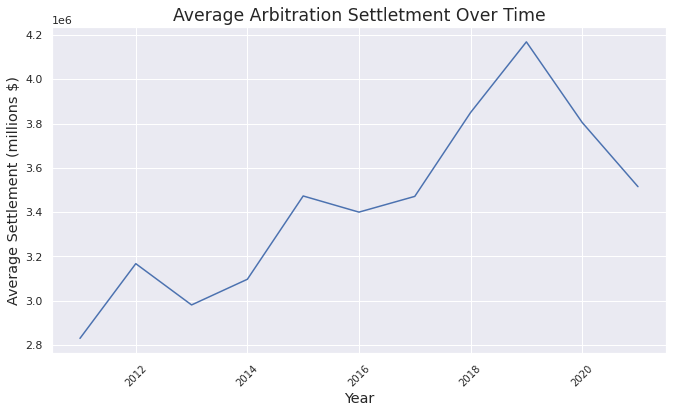

In [24]:
players.groupby(['Year'])['Settled_Amount'].mean().plot()
plt.xlabel("Year", fontsize = LABEL_SIZE)
plt.ylabel("Average Settlement (millions $)", fontsize = LABEL_SIZE)
plt.xticks(fontsize=10, rotation=45)
plt.title("Average Arbitration Settletment Over Time", fontsize = TITLE_SIZE)
plt.show()

Labor spending fluctuated quite a bit but generally went up over time. It will be helpful to normalize these salaries for our modeling. We'll then replot the salaries to ensure the normalization was done correctly.

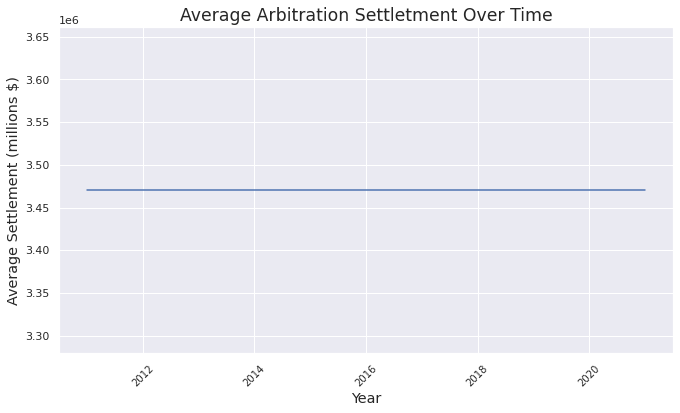

In [25]:
norm_salary = dict()

for year in players['Year'].unique():
    norm_salary[year] = players[players['Year'] == year]['Settled_Amount'].mean() / players['Settled_Amount'].mean()

players['Norm_Settled_Amount'] = players.apply(lambda x: x['Settled_Amount'] / norm_salary[x['Year']], axis = 1)

players.groupby(['Year'])['Norm_Settled_Amount'].mean().plot()
plt.xlabel("Year", fontsize = LABEL_SIZE)
plt.ylabel("Average Settlement (millions $)", fontsize = LABEL_SIZE)
plt.xticks(fontsize=10, rotation=45)
plt.title("Average Arbitration Settletment Over Time", fontsize = TITLE_SIZE)
plt.show()

Now let's look at how salary varies by position. Position isn't included in the arbitration dataset or the pitching/batting datasets but we can retrieve it by examining the *Fielding* table in the databank.

In [26]:
fielding.head()

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,abercda01,1871,1,TRO,NaN,SS,1,1.0,24.0,1,3,2.0,0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,2B,22,22.0,606.0,67,72,42.0,5,NaN,NaN,NaN,NaN,NaN
2,addybo01,1871,1,RC1,NaN,SS,3,3.0,96.0,8,14,7.0,0,NaN,NaN,NaN,NaN,NaN
3,allisar01,1871,1,CL1,NaN,2B,2,0.0,18.0,1,4,0.0,0,NaN,NaN,NaN,NaN,NaN
4,allisar01,1871,1,CL1,NaN,OF,29,29.0,729.0,51,3,7.0,1,NaN,NaN,NaN,NaN,NaN


For each season, every player has recorded cumulative fielding statistics for each position they played. We can then create a function that sorts the table by player and season to find out what their primary position was for the season.

In [27]:
def get_primary_position(pid, year, stats = fielding, display_test = False):
    stats = stats[(stats['playerID'] == pid) & (stats['yearID'] == year)].sort_values(by='InnOuts', ascending=False)
    if display_test == True:
        display(stats)
    return(stats.iloc[0]['POS'])

#test function
print(get_primary_position('molinya01', year = 2019, display_test = True))
print(get_primary_position('martipe02', year = 1999, display_test = True))


,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
142179,molinya01,2019,1,SLN,NL,C,111,108.0,2818.0,916,30,1.0,5,4.0,NaN,22.0,8.0,NaN
142177,molinya01,2019,1,SLN,NL,1B,4,0.0,24.0,6,0,0.0,1,NaN,NaN,NaN,NaN,NaN
142178,molinya01,2019,1,SLN,NL,3B,1,0.0,3.0,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN


C


,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
105759,martipe02,1999,1,BOS,AL,P,31,29.0,640.0,13,15,1.0,0,NaN,NaN,NaN,NaN,NaN


P


In [28]:
players['Position'] = players.apply(lambda x: get_primary_position(x['playerID'], x['Year']), axis = 1)
players.head()

,nameFull,playerID,birthYear,Team,Service_Time,Settled_Amount,Year,Team_Won_Arb_Hearing,Player_Won_Arb_Hearing,Super_Two_Eligible,franchID,Norm_Settled_Amount,Position
55,BrandonLeague,leagubr01,1983.0,Mariners,4.145,2250000,2011,False,False,False,SEA,2.758877e+06,P
108,JasonVargas,vargaja01,1983.0,Mariners,3.114,2450000,2011,False,False,False,SEA,3.004110e+06,P
188,MikeAdams,adamsmi03,1978.0,Padres,4.019,2535000,2011,False,False,False,SDN,3.108335e+06,P
238,HeathBell,bellhe01,1977.0,Padres,5.099,7500000,2011,False,False,False,SDN,9.196256e+06,P
288,ChrisDenorfia,denorch01,1980.0,Padres,3.041,800000,2011,False,False,False,SDN,9.809340e+05,OF


Now that we have the positional data, let's begin our data exploration by looking at how salary varies by position.

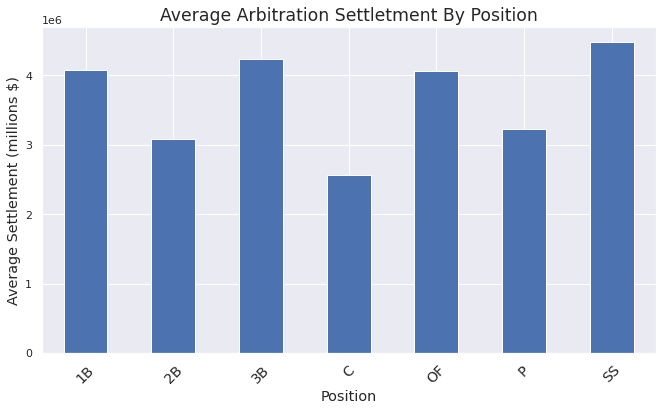

In [29]:
players.groupby('Position')['Norm_Settled_Amount'].mean().plot.bar()
 
plt.xlabel("Position", fontsize = LABEL_SIZE)
plt.ylabel("Average Settlement (millions $)", fontsize = LABEL_SIZE)
plt.xticks(fontsize=X_TICKS, rotation=45)
plt.title("Average Arbitration Settletment By Position", fontsize = TITLE_SIZE)
plt.show()

There's definitely some salary variance between positions. Short Stop seems to be considered a premium position and fetches the highest salary while catchers seem to fetch the lowest. Let's continue our exploration by looking at how the average arbitration settlement has changed over time.

Let's see what effect starting an all-star game has on salary. Let's look at the *AllstarFull* table in the databank.

In [30]:
print(all_star['yearID'].unique())

[1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946
 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2021]


You'll notice that all star data isn't included for 2020. During that season the all star game was cancelled due to the pandemic.

Let's create a function that will lookup whether a player in a ceratain season made the all star team.

In [31]:
all_star = all_star[all_star['yearID'] >= 2005]
all_star.head(100)

def get_all_star(playerID, yearID, all_s = all_star):
    all_s = all_s[all_s['yearID'] == yearID]
    if playerID in all_s['playerID'].unique():
        return True
    else:
        return False


Finally we'll run this over the players table. Note that we subtract 1 from the year of arbitration because we want to know if an all star appearance affected their salary for the following year.

In [32]:
players['All_Star'] = players.apply(lambda x: get_all_star(x['playerID'], x['Year'] - 1), axis = 1)
players[players['All_Star'] == True].head()

,nameFull,playerID,birthYear,Team,Service_Time,Settled_Amount,Year,Team_Won_Arb_Hearing,Player_Won_Arb_Hearing,Super_Two_Eligible,franchID,Norm_Settled_Amount,Position,All_Star
238,HeathBell,bellhe01,1977.0,Padres,5.099,7500000,2011,False,False,False,SDN,9.196256e+06,P,True
709,JeredWeaver,weaveje02,1982.0,Angels,4.129,7365000,2011,False,True,False,LAA,9.030724e+06,P,True
1000,MichaelBourn,bournmi01,1982.0,Astros,4.028,4400000,2011,False,False,False,HOU,5.395137e+06,OF,True
1758,Hung-ChihKuo,kuoho01,1981.0,Dodgers,4.114,2725000,2011,False,False,False,LAN,3.341306e+06,P,True
3001,MattCapps,cappsma01,1983.0,Twins,5.017,7150000,2011,False,False,False,MIN,8.767098e+06,P,True


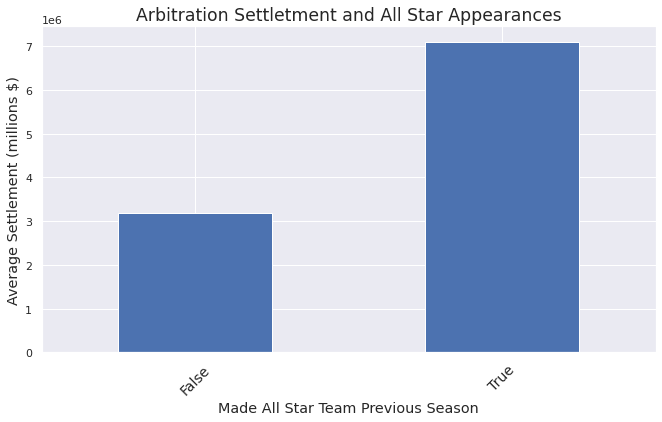

In [33]:
players.groupby('All_Star')['Norm_Settled_Amount'].mean().plot.bar()
 
plt.xlabel("Made All Star Team Previous Season", fontsize = LABEL_SIZE)
plt.ylabel("Average Settlement (millions $)", fontsize = LABEL_SIZE)
plt.xticks(fontsize=X_TICKS, rotation=45)
plt.title("Arbitration Settletment and All Star Appearances", fontsize = TITLE_SIZE)
plt.show()

Clearly making the allstar team has a huge impact on player's arbitration settlement and it will be included in our model.

Now let's quickly examine the player statistics that we'll later use in our model:

In [34]:
display(stats_pitching.head())
print(stats_pitching.columns)
display(stats_batting.head())
print(stats_batting.columns)

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
36248,accarje01,2005,1,SFN,NL,1,5,28,0,0,...,1.0,1,1.0,0,124.0,7,13,1.0,1.0,3.0
36249,acevejo01,2005,1,COL,NL,2,4,36,5,0,...,3.0,0,1.0,1,292.0,7,48,2.0,5.0,3.0
36250,adamsmi03,2005,1,MIL,NL,0,1,13,0,0,...,1.0,1,0.0,0,61.0,7,4,0.0,0.0,1.0
36251,adamste01,2005,1,PHI,NL,0,2,16,0,0,...,2.0,0,4.0,0,77.0,5,19,1.0,0.0,2.0
36252,adkinjo01,2005,1,CHA,AL,0,1,5,0,0,...,2.0,0,1.0,0,42.0,4,8,0.0,0.0,1.0


Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
86000,abernbr01,2005,1,MIN,AL,24,67,5,16,1,...,6.0,2.0,0.0,7,9.0,0.0,1.0,3.0,1.0,2.0
86001,abreubo01,2005,1,PHI,NL,162,588,104,168,37,...,102.0,31.0,9.0,117,134.0,15.0,6.0,0.0,8.0,7.0
86002,accarje01,2005,1,SFN,NL,28,2,0,1,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
86003,acevejo01,2005,1,COL,NL,36,8,0,1,0,...,0.0,0.0,0.0,1,6.0,0.0,1.0,1.0,0.0,0.0
86004,adamsmi03,2005,1,MIL,NL,13,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')


Obviously the statistics kept for batters and pitchers are different and we'll eventually need to train separate models for each. Now let's examine how tenure affects salary arbitration:

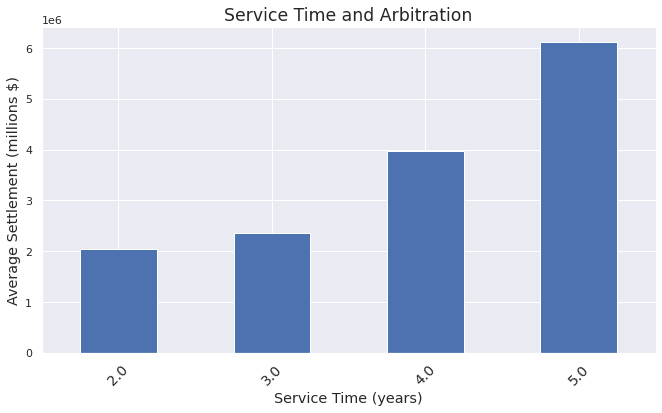

In [35]:
players['Serve'] = players['Service_Time'].apply(np.floor)
#There are three players who in the dataset who were arbitration eligible after 6 years due to special circumstances
#and will be excluded from the graph for posterity
players[players['Serve'] < 6].groupby('Serve')['Norm_Settled_Amount'].mean().plot.bar()
 
plt.xlabel("Service Time (years)", fontsize = LABEL_SIZE)
plt.ylabel("Average Settlement (millions $)", fontsize = LABEL_SIZE)
plt.xticks(fontsize=X_TICKS, rotation=45)
plt.title("Service Time and Arbitration", fontsize = TITLE_SIZE)
plt.show()
players.drop(['Serve'], axis = 1);


Let's move on to examining statistics and examine some distributions of common batting and pitching statistics. We'll filter outliers by removing players without requisite playing time. As with most statistics in baseball, home runs and strikeouts are logarithmically distributed.

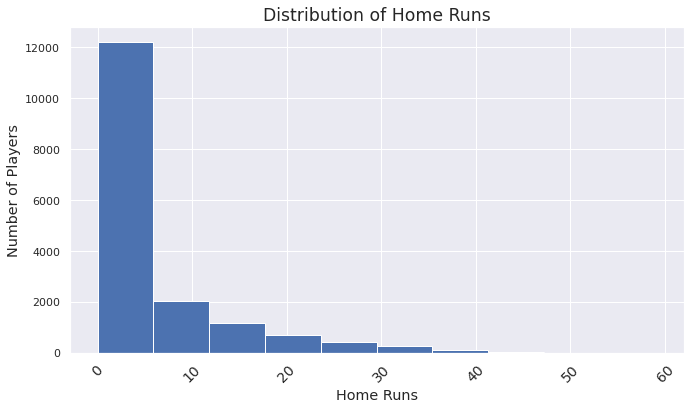

In [36]:
stats_batting[stats_batting['AB'] > stats_batting['AB'].quantile(.25)]['HR'].plot.hist(bins = 10)
 
plt.xlabel("Home Runs", fontsize = LABEL_SIZE)
plt.ylabel("Number of Players", fontsize = LABEL_SIZE)
plt.xticks(fontsize=X_TICKS, rotation=45)
plt.title("Distribution of Home Runs", fontsize = TITLE_SIZE)
plt.show()

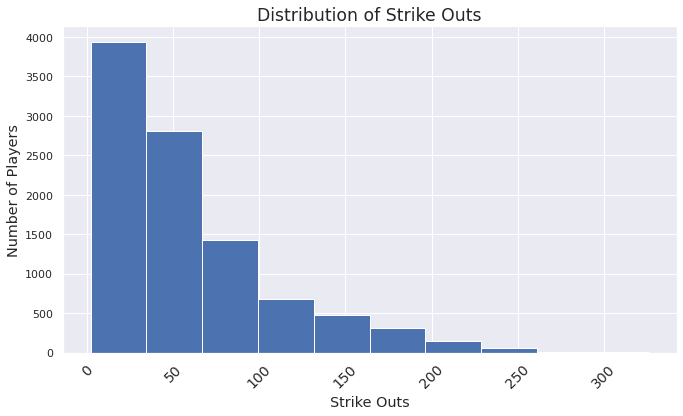

In [37]:
stats_pitching[stats_pitching['IPouts'] > stats_pitching['IPouts'].quantile(.25)]['SO'].plot.hist(bins = 10)
 
plt.xlabel("Strike Outs", fontsize = LABEL_SIZE)
plt.ylabel("Number of Players", fontsize = LABEL_SIZE)
plt.xticks(fontsize=X_TICKS, rotation=45)
plt.title("Distribution of Strike Outs", fontsize = TITLE_SIZE)
plt.show()

Now we're ready to move on to our modeling.

## Modeling

### Baseline Model

In [38]:
import numpy as np
import statsmodels.api as sm

Let's look at the distribution of our target variable, *Norm_Settled_Amount*.

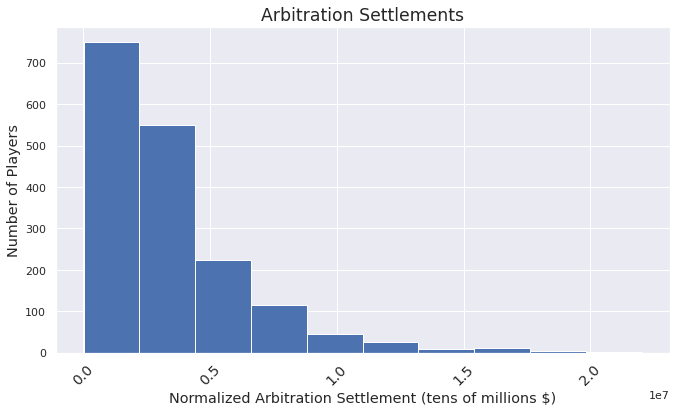

In [39]:
players['Norm_Settled_Amount'].plot.hist(bins = 10)
plt.xlabel("Normalized Arbitration Settlement (tens of millions $)", fontsize = LABEL_SIZE)
plt.ylabel("Number of Players", fontsize = LABEL_SIZE)
plt.xticks(fontsize=X_TICKS, rotation=45)
plt.title("Arbitration Settlements", fontsize = TITLE_SIZE)
plt.show()

One of the assumptions of linear regression is linearity for the target variable. Arbitration settlements are clearly logarithmically distributed so we'll need transform them to a normal distribution before doing our modeling.

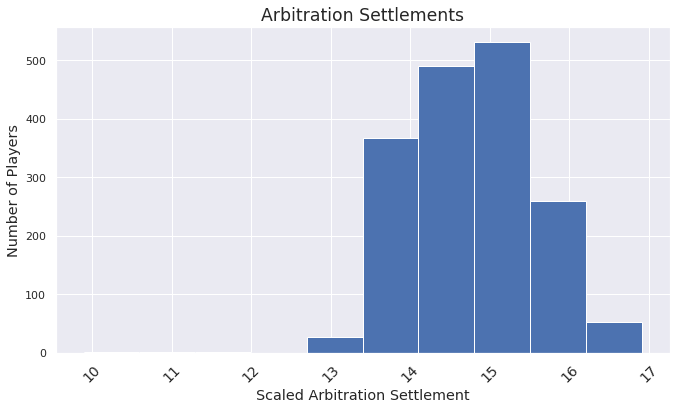

In [40]:
players['Scaled_Settled_Amount'] = np.log(players['Norm_Settled_Amount'])
players['Scaled_Settled_Amount'].plot.hist(bins = 10)
plt.xlabel("Scaled Arbitration Settlement", fontsize = LABEL_SIZE)
plt.ylabel("Number of Players", fontsize = LABEL_SIZE)
plt.xticks(fontsize=X_TICKS, rotation=45)
plt.title("Arbitration Settlements", fontsize = TITLE_SIZE)
plt.show()

It's likely that salary arbitrations are greatly influenced by previous salary history. We'll create a function that will pull in player's salary from the previous season to use as a feature.

In [41]:
def get_prev_scaled_settled_amount(x, play = players):
    year = x['Year'] - 1
    pid = x['playerID']
    try:
        y = players[(players['Year'] == year ) & (players['playerID'] == pid)]
        return y['Scaled_Settled_Amount'].item()
    except:
        return 0

players['Prev_Scaled_Settled_Amount'] = players.apply(lambda x: get_prev_scaled_settled_amount(x), axis = 1)

In [42]:
players_copy = players.copy()

We're going to include some categorical values in our model. Most importantly, whether or not the player made the all star team the year prior will be included. The columns describing who won the arbitration hearing will be included for now, although they shouldn't be expected to have much predictive value. We'll need to one-hot encode these variables to fit our model. 

In [43]:
players = players_copy
players['Age'] = players['Year'] - players['birthYear']

players = pd.get_dummies(players, columns=['All_Star', 'Player_Won_Arb_Hearing', 'Team_Won_Arb_Hearing'], drop_first=True)


In [44]:
player_preds = players[['Service_Time', 'Age', 'Prev_Scaled_Settled_Amount', 'All_Star_True', 'Player_Won_Arb_Hearing_True', 'Team_Won_Arb_Hearing_True']]
player_target = players['Scaled_Settled_Amount']


In [45]:
predictors = sm.add_constant(player_preds)
#predictors
model = sm.OLS(player_target, predictors).fit()
model.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Scaled_Settled_Amount   R-squared:                       0.404
Model:                               OLS   Adj. R-squared:                  0.402
Method:                    Least Squares   F-statistic:                     194.8
Date:                   Tue, 04 Oct 2022   Prob (F-statistic):          9.08e-190
Time:                           03:20:25   Log-Likelihood:                -1596.5
No. Observations:                   1734   AIC:                             3207.
Df Residuals:                       1727   BIC:                             3245.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          16.0400      0.211     76.047      0.000      15.626      16.454
Service_Time                    0.3927      0.020     19.495      0.000       0.353       0.432
Age                            -0.0997      0.008    -12.779      0.000      -0.115      -0.084
Prev_Scaled_Settled_Amount      0.0192      0.002      7.901      0.000       0.014       0.024
All_Star_True                   0.7101      0.057     12.475      0.000       0.598       0.822
Player_Won_Arb_Hearing_True     0.2099      0.091      2.298      0.022       0.031       0.389
Team_Won_Arb_Hearing_True       0.3804      0.095      3.993      0.000       0.194       0.567
==============================================================================
Omnibus:                      357.992   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2687.928
Skew:                          -0.758   Prob(JB):                         0.00
Kurtosis:                       8.908   Cond. No.                         436.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Without including any statistics in our model we get a rather paltry Adj. R-squared of 0.380. That is, about 38% of the variance in out target variable *Scaled_Settled_Amount* is explained by our predictors. Hopefully this can be improved upon by adding statistics to our model.

### Model Iteration

Let's integrate some statistics to improve our model. We'll have to split the dataset between batters and pitchers and we'll focus on batters going forward.

In [46]:
players['Prev_Year'] = players['Year'] - 1
batters = players[players['Position'] != 'P']
pitchers = players[players['Position'] == 'P']

batters = pd.merge(batters, stats_batting, how = 'inner', \
                   left_on = ['playerID', 'Prev_Year'], right_on = ['playerID', 'yearID'])

pitchers = pd.merge(pitchers, stats_pitching, how = 'inner', \
                   left_on = ['playerID', 'Prev_Year'], right_on = ['playerID', 'yearID'])

batters.head()

,nameFull,playerID,birthYear,Team,Service_Time,Settled_Amount,Year,Super_Two_Eligible,franchID,Norm_Settled_Amount,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,ChrisDenorfia,denorch01,1980.0,Padres,3.041,800000,2011,False,SDN,9.809340e+05,...,36.0,8.0,4.0,27,51.0,3.0,2.0,1.0,3.0,5.0
1,ChaseHeadley,headlch01,1984.0,Padres,2.123,2535000,2011,True,SDN,3.108335e+06,...,58.0,17.0,5.0,56,139.0,3.0,3.0,1.0,4.0,11.0
2,RyanLudwick,ludwiry01,1978.0,Padres,5.109,6775000,2011,False,SDN,8.307285e+06,...,43.0,0.0,3.0,24,64.0,0.0,4.0,0.0,3.0,4.0
3,RyanLudwick,ludwiry01,1978.0,Padres,5.109,6775000,2011,False,SDN,8.307285e+06,...,26.0,0.0,1.0,24,57.0,0.0,4.0,0.0,2.0,9.0
4,ErickAybar,aybarer01,1984.0,Angels,4.086,3000000,2011,False,LAA,3.678503e+06,...,29.0,22.0,8.0,35,81.0,1.0,7.0,11.0,2.0,7.0


In [47]:
batters.columns

Index(['nameFull', 'playerID', 'birthYear', 'Team', 'Service_Time',
       'Settled_Amount', 'Year', 'Super_Two_Eligible', 'franchID',
       'Norm_Settled_Amount', 'Position', 'Serve', 'Scaled_Settled_Amount',
       'Prev_Scaled_Settled_Amount', 'Age', 'All_Star_True',
       'Player_Won_Arb_Hearing_True', 'Team_Won_Arb_Hearing_True', 'Prev_Year',
       'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP'],
      dtype='object')

Traditionally, the most important statistics for batters are batting average, home runs, and RBI (leading the league in all three wins the player the rare "Triple Crown"). We'll begin by looking at these. First we'll turn each into a rate to make them easier to analyze. We'll also calculate OBP which is a measurement of the percentage of plate appearances a batter gets on base and SLG which is a measurement of the average total number of bases per AB for the batter.

In [48]:
batters['OBP'] = (batters['H'] + batters['BB'] + batters['HBP']) / \
(batters['AB'] + (batters['BB'] + batters['HBP'] + batters['SF']))
#(1B + 2Bx2 + 3Bx3 + HRx4)/AB.
batters['SLG'] = (batters['H'] + 2*batters['2B'] + 3*batters['3B'] + 4*batters['HR']) / batters['AB']
batters['OPS'] = batters['OBP'] + batters['SLG']

batters['R'] = batters['R'] / batters['AB']
batters['AVG'] = batters['H'] / batters['AB']
batters['HR'] = batters['HR'] / batters['AB']
batters['RBI'] = batters['RBI'] / batters['AB']
batters['SB'] = batters['SB'] / batters['AB']
batters.head()

,nameFull,playerID,birthYear,Team,Service_Time,Settled_Amount,Year,Super_Two_Eligible,franchID,Norm_Settled_Amount,...,SO,IBB,HBP,SH,SF,GIDP,OBP,SLG,OPS,AVG
0,ChrisDenorfia,denorch01,1980.0,Padres,3.041,800000,2011,False,SDN,9.809340e+05,...,51.0,3.0,2.0,1.0,3.0,5.0,0.335443,0.524648,0.860091,0.271127
1,ChaseHeadley,headlch01,1984.0,Padres,2.123,2535000,2011,True,SDN,3.108335e+06,...,139.0,3.0,3.0,1.0,4.0,11.0,0.326895,0.445902,0.772796,0.263934
2,RyanLudwick,ludwiry01,1978.0,Padres,5.109,6775000,2011,False,SDN,8.307285e+06,...,64.0,0.0,4.0,0.0,3.0,4.0,0.342949,0.601423,0.944372,0.281139
3,RyanLudwick,ludwiry01,1978.0,Padres,5.109,6775000,2011,False,SDN,8.307285e+06,...,57.0,0.0,4.0,0.0,2.0,9.0,0.301255,0.392344,0.693600,0.210526
4,ErickAybar,aybarer01,1984.0,Angels,4.086,3000000,2011,False,LAA,3.678503e+06,...,81.0,1.0,7.0,11.0,2.0,7.0,0.306228,0.380150,0.686378,0.252809


For the one-hot encoding for position we'll need to create dummy variables for each position.

In [49]:
batters = pd.get_dummies(batters, columns=['Position'], drop_first=True)

In [50]:
pred_columns = ['Service_Time', 'Age', 'All_Star_True', 'Prev_Scaled_Settled_Amount', 'R', 'HR', 'RBI', 'SB', 'AVG', 'Position_2B', \
                   'Position_3B', 'Position_C', 'Position_OF', 'Position_SS']
batters[pred_columns].head()

,Service_Time,Age,All_Star_True,Prev_Scaled_Settled_Amount,R,HR,RBI,SB,AVG,Position_2B,Position_3B,Position_C,Position_OF,Position_SS
0,3.041,31.0,0,0.0,0.144366,0.031690,0.126761,0.028169,0.271127,0,0,0,1,0
1,2.123,27.0,0,0.0,0.126230,0.018033,0.095082,0.027869,0.263934,0,1,0,0,0
2,5.109,33.0,0,0.0,0.156584,0.039146,0.153025,0.000000,0.281139,0,0,0,1,0
3,5.109,33.0,0,0.0,0.090909,0.028708,0.124402,0.000000,0.210526,0,0,0,1,0
4,4.086,27.0,0,0.0,0.129213,0.009363,0.054307,0.041199,0.252809,0,0,0,0,1


In [51]:
batters_preds = batters[pred_columns]
batters_target = batters['Scaled_Settled_Amount']
predictors = sm.add_constant(batters_preds)
model = sm.OLS(batters_target, predictors).fit()
model.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Scaled_Settled_Amount   R-squared:                       0.516
Model:                               OLS   Adj. R-squared:                  0.508
Method:                    Least Squares   F-statistic:                     60.93
Date:                   Tue, 04 Oct 2022   Prob (F-statistic):          9.70e-116
Time:                           03:20:26   Log-Likelihood:                -672.94
No. Observations:                    815   AIC:                             1376.
Df Residuals:                        800   BIC:                             1446.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         14.8307      0.330     44.946      0.000      14.183      15.478
Service_Time                   0.3748      0.026     14.158      0.000       0.323       0.427
Age                           -0.0846      0.011     -7.718      0.000      -0.106      -0.063
All_Star_True                  0.4418      0.078      5.649      0.000       0.288       0.595
Prev_Scaled_Settled_Amount     0.0125      0.003      3.865      0.000       0.006       0.019
R                              1.0691      0.780      1.370      0.171      -0.462       2.601
HR                            10.7958      1.718      6.285      0.000       7.424      14.168
RBI                           -0.6794      0.771     -0.881      0.378      -2.192       0.834
SB                            -0.4963      0.993     -0.500      0.617      -2.446       1.453
AVG                            2.1682      0.618      3.511      0.000       0.956       3.380
Position_2B                   -0.0899      0.088     -1.023      0.307      -0.262       0.083
Position_3B                    0.1645      0.084      1.969      0.049       0.000       0.328
Position_C                    -0.1934      0.076     -2.531      0.012      -0.343      -0.043
Position_OF                    0.1249      0.070      1.780      0.076      -0.013       0.263
Position_SS                    0.1607      0.084      1.906      0.057      -0.005       0.326
==============================================================================
Omnibus:                      328.391   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4179.373
Skew:                          -1.460   Prob(JB):                         0.00
Kurtosis:                      13.703   Cond. No.                     2.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our first iteration definitely has improved perforance as evidenced by its Adjusted R-Squared value of 0.508, but its high condition number suggests issues with multicollinearity. This makes sense, as many of the statistics, such as home runs and RBI, are collinear. We'll need to continue tinkering to see if we can lower this while retaining our performance. Let's examine which features in the stats dataset have the strongest correlation to the settlement amount and which ones are potentially confounding.

In [52]:
stats_cols = ['HR', 'RBI', 'SB', 'AVG', 'OBP', 'SLG', 'OPS', 'Scaled_Settled_Amount']
batters[stats_cols].corr()

,HR,RBI,SB,AVG,OBP,SLG,OPS,Scaled_Settled_Amount
HR,1.000000,0.788453,-0.290325,0.218558,0.283809,0.805603,0.721114,0.394283
RBI,0.788453,1.000000,-0.311368,0.337490,0.360519,0.733828,0.687360,0.334915
SB,-0.290325,-0.311368,1.000000,0.132833,0.081578,-0.128972,-0.077472,-0.006895
AVG,0.218558,0.337490,0.132833,1.000000,0.780749,0.663550,0.757492,0.315301
OBP,0.283809,0.360519,0.081578,0.780749,1.000000,0.607377,0.778676,0.324752
SLG,0.805603,0.733828,-0.128972,0.663550,0.607377,1.000000,0.971386,0.436700
OPS,0.721114,0.687360,-0.077472,0.757492,0.778676,0.971386,1.000000,0.441996
Scaled_Settled_Amount,0.394283,0.334915,-0.006895,0.315301,0.324752,0.436700,0.441996,1.000000


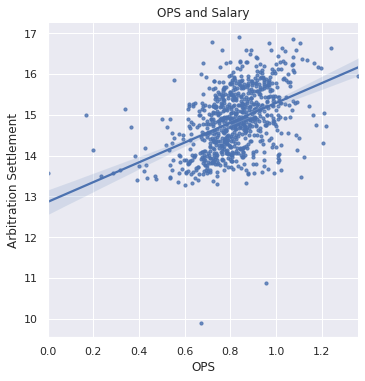

In [53]:
sns.lmplot(data=batters, x='OPS', y='Scaled_Settled_Amount', scatter_kws={'s': 10})
plt.xlabel('OPS')
plt.ylabel('Arbitration Settlement')
plt.title('OPS and Salary');

OPS has the strongest correlation out of all the stats but is only slightly stronger than SLG. Note that OPS and SLG are highly correlated and are definitely confounding variables. OPS is simply the sum of OBP and SLG so this is unsurprising. Most of these statistics are highly correlated with OPS except for SB. Let's try running the model with SB and OPS and see its performance.

In [54]:
pred_columns = ['Service_Time', 'Age', 'All_Star_True', 'Prev_Scaled_Settled_Amount', 'OPS', 'SB', 'Position_2B', \
                   'Position_3B', 'Position_C', 'Position_OF', 'Position_SS']

batters_preds = batters[pred_columns]
predictors = sm.add_constant(batters_preds)
model = sm.OLS(batters_target, predictors).fit()
model.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Scaled_Settled_Amount   R-squared:                       0.505
Model:                               OLS   Adj. R-squared:                  0.498
Method:                    Least Squares   F-statistic:                     74.40
Date:                   Tue, 04 Oct 2022   Prob (F-statistic):          1.42e-114
Time:                           03:20:26   Log-Likelihood:                -682.33
No. Observations:                    815   AIC:                             1389.
Df Residuals:                        803   BIC:                             1445.
Df Model:                             11                                         
Covariance Type:               nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         14.5903      0.332     43.929      0.000      13.938      15.242
Service_Time                   0.3715      0.027     13.952      0.000       0.319       0.424
Age                           -0.0879      0.011     -7.965      0.000      -0.110      -0.066
All_Star_True                  0.4601      0.079      5.854      0.000       0.306       0.614
Prev_Scaled_Settled_Amount     0.0142      0.003      4.385      0.000       0.008       0.021
OPS                            1.6077      0.150     10.700      0.000       1.313       1.903
SB                            -1.2246      0.920     -1.331      0.184      -3.031       0.582
Position_2B                   -0.1246      0.087     -1.437      0.151      -0.295       0.046
Position_3B                    0.1292      0.084      1.543      0.123      -0.035       0.294
Position_C                    -0.2011      0.077     -2.613      0.009      -0.352      -0.050
Position_OF                    0.1146      0.070      1.643      0.101      -0.022       0.252
Position_SS                    0.1254      0.083      1.514      0.130      -0.037       0.288
==============================================================================
Omnibus:                      309.241   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3852.234
Skew:                          -1.355   Prob(JB):                         0.00
Kurtosis:                      13.300   Cond. No.                     1.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our condition number is still too high. We'll need to remove SB from our final model afterall.

### Final Model

In [55]:
pred_columns = ['Service_Time', 'Age', 'All_Star_True', 'Prev_Scaled_Settled_Amount', 'OPS', 'Position_2B', \
                   'Position_3B', 'Position_C', 'Position_OF', 'Position_SS']

batters_preds = batters[pred_columns]
predictors = sm.add_constant(batters_preds)
model = sm.OLS(batters_target, predictors).fit()
model.summary()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Scaled_Settled_Amount   R-squared:                       0.504
Model:                               OLS   Adj. R-squared:                  0.497
Method:                    Least Squares   F-statistic:                     81.59
Date:                   Tue, 04 Oct 2022   Prob (F-statistic):          3.66e-115
Time:                           03:20:26   Log-Likelihood:                -683.23
No. Observations:                    815   AIC:                             1388.
Df Residuals:                        804   BIC:                             1440.
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         14.5595      0.331     43.922      0.000      13.909      15.210
Service_Time                   0.3720      0.027     13.967      0.000       0.320       0.424
Age                           -0.0881      0.011     -7.978      0.000      -0.110      -0.066
All_Star_True                  0.4518      0.078      5.763      0.000       0.298       0.606
Prev_Scaled_Settled_Amount     0.0142      0.003      4.377      0.000       0.008       0.021
OPS                            1.6403      0.148     11.060      0.000       1.349       1.931
Position_2B                   -0.1401      0.086     -1.629      0.104      -0.309       0.029
Position_3B                    0.1230      0.084      1.470      0.142      -0.041       0.287
Position_C                    -0.1945      0.077     -2.532      0.012      -0.345      -0.044
Position_OF                    0.0875      0.067      1.311      0.190      -0.044       0.219
Position_SS                    0.1078      0.082      1.317      0.188      -0.053       0.268
==============================================================================
Omnibus:                      314.157   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4100.094
Skew:                          -1.369   Prob(JB):                         0.00
Kurtosis:                      13.642   Cond. No.                         519.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Results and Further Analysis

Our final model has a disappointing Adj. R-squared of 0.497, i.e. only about half of the variance in arbitration settlment is explained by our model. Clearly there are other factors outside of accumulated stats and our bio features that are influencing negotiated salary. I hypothesize that player draft position likely has a high effect on the negotiated salary, that is, highly-touted prospect probably have much more bargaining power than un-touted ones especially early on in player's careers, regardless of statistics. Further investigation would require additional data sources. Unfortunately, with the performance of the model as it stands now it wouldn't be very useful in predicting salaries for players that are arbitration-eligible. 

Let's dig into the coefficients of our predictors. Because we normalized and scaled our target variable Arbitration_Settlement, the units are convoluted but still represent dollars in salary.OPS (1.6403) shows that a marginal increase in the stat has a large effect on our target variable. All Star Apperance (0.4518) also has a large effect, as does Service_Time (0.3720). Previous salary *Prev_Scaled_Settled_Amount* seems to have a rather small effect (0.0142). Interestingly, Age (-0.0881) negatively affects Salary. Clearly teams put a premium on youth when it comes to salary negotiation and projecting future performance.

Our positional categorical values confirm what we saw earlier: 2B (-0.1401) and C (-0.1945) are financially penalized for their position, while 3B (0.1230), OF (0.0875), and SS (0.1078) fetch a premium. The constant 14.5595 shows the baseline salary for a player in the arbitration process that has accumulated zero counting stats.

Let's continue our analysis by examining which features have the most impact on our target variable.

In [56]:
pred_columns.append('Scaled_Settled_Amount')
batters[pred_columns].corr()

,Service_Time,Age,All_Star_True,Prev_Scaled_Settled_Amount,OPS,Position_2B,Position_3B,Position_C,Position_OF,Position_SS,Scaled_Settled_Amount
Service_Time,1.000000,0.398460,0.086185,0.545691,0.106230,0.027002,-0.061134,-0.013415,0.016791,0.005279,0.486220
Age,0.398460,1.000000,-0.099754,0.132325,-0.072988,-0.017736,-0.041528,0.143847,0.001097,-0.154198,-0.083375
All_Star_True,0.086185,-0.099754,1.000000,-0.014112,0.275003,-0.020445,0.059263,0.013368,-0.034668,0.028179,0.296742
Prev_Scaled_Settled_Amount,0.545691,0.132325,-0.014112,1.000000,0.027445,0.024987,-0.047729,0.005052,0.001112,0.018081,0.356257
OPS,0.106230,-0.072988,0.275003,0.027445,1.000000,-0.075020,0.075831,-0.206214,0.138790,-0.039015,0.441996
Position_2B,0.027002,-0.017736,-0.020445,0.024987,-0.075020,1.000000,-0.117844,-0.152980,-0.259332,-0.127214,-0.069893
Position_3B,-0.061134,-0.041528,0.059263,-0.047729,0.075831,-0.117844,1.000000,-0.161151,-0.273183,-0.134008,0.055630
Position_C,-0.013415,0.143847,0.013368,0.005052,-0.206214,-0.152980,-0.161151,1.000000,-0.354635,-0.173964,-0.216782
Position_OF,0.016791,0.001097,-0.034668,0.001112,0.138790,-0.259332,-0.273183,-0.354635,1.000000,-0.294904,0.117241
Position_SS,0.005279,-0.154198,0.028179,0.018081,-0.039015,-0.127214,-0.134008,-0.173964,-0.294904,1.000000,0.078103


The most important features in our model are Service_Time, OPS, Prev_Scaled_Settled_Amount, and All_Star_True, in that order. Those are the only features that have a large effect, although using the others is still beneficial.

We've already identified that OPS is the statistical feature that best predicts the salary arbitration outcome. Is OPS also the most important in scoring runs and winning games?

Let's look at our last table for the project.

In [57]:
teams_id.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')

We'll run some quick calculations and then we'll look at the correlation matrix and visualize the relationship between total runs scored by team and the other statistical categories.

In [58]:
teams_id['OBP'] = (teams_id['H'] + teams_id['BB'] + teams_id['HBP']) / \
(teams_id['AB'] + (teams_id['BB'] + teams_id['HBP'] + teams_id['SF']))
teams_id['SLG'] = (teams_id['H'] + 2*teams_id['2B'] + 3*teams_id['3B'] + 4*teams_id['HR']) / teams_id['AB']
teams_id['OPS'] = teams_id['OBP'] + teams_id['SLG']
teams_id['AVG'] = teams_id['H'] / teams_id['AB']
stats_cols = ['R', 'W', 'HR', 'SB', 'AVG', 'OBP', 'SLG', 'OPS']
teams_id[stats_cols].corr()

,R,W,HR,SB,AVG,OBP,SLG,OPS
R,1.000000,0.701589,0.496322,0.205986,0.637360,0.651780,0.697585,0.681088
W,0.701589,1.000000,0.477223,0.081035,0.318900,0.417828,0.492606,0.346537
HR,0.496322,0.477223,1.000000,-0.382341,0.058455,0.388370,0.797164,0.746843
SB,0.205986,0.081035,-0.382341,1.000000,0.074359,0.061071,-0.262156,-0.116608
AVG,0.637360,0.318900,0.058455,0.074359,1.000000,0.832501,0.566528,0.708344
OBP,0.651780,0.417828,0.388370,0.061071,0.832501,1.000000,0.668860,0.803741
SLG,0.697585,0.492606,0.797164,-0.262156,0.566528,0.668860,1.000000,0.979891
OPS,0.681088,0.346537,0.746843,-0.116608,0.708344,0.803741,0.979891,1.000000


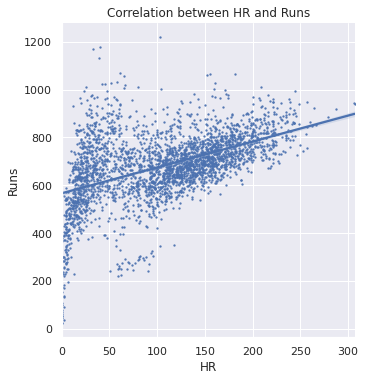

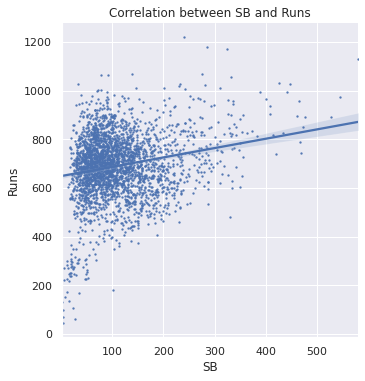

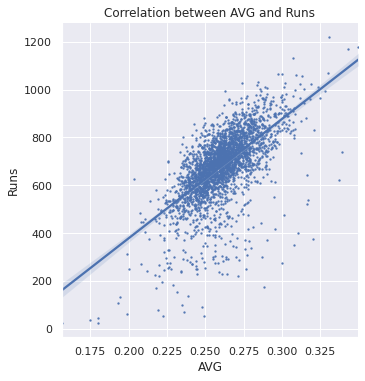

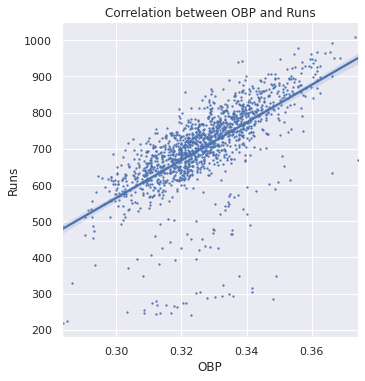

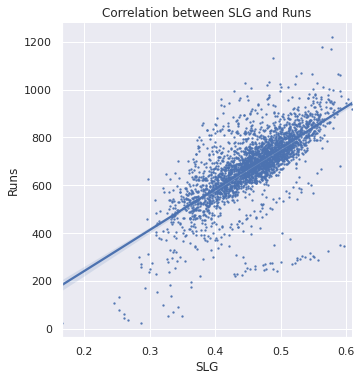

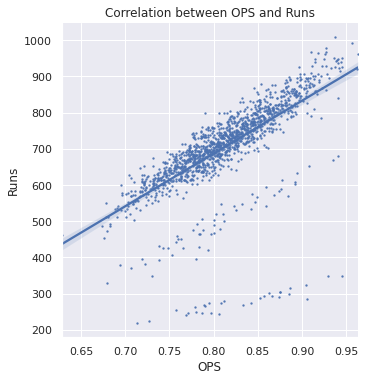

In [59]:
for stat in stats_cols[2:]:
    sns.lmplot(data=teams_id, x=stat, y='R', scatter_kws={'s': 2})
    plt.xlabel(stat)
    plt.ylabel('Runs')
    plt.title('Correlation between {} and Runs'.format(stat));

When it comes to scoring, the two best predictive metrics are SLG and OPS as 0.698 and 0.681 correlation, respectively. As previously stated, both of these statistics are highly confounding so it's unsurpising that their correlations are extremely similar.

Back to one of our original questions: *Does salary negotiation during the arbitration process correctly reflect what best contributes to winning in baseball?* It seems like the answer is indeed yes. OPS/SLG are the best predictors of how well an baseball club's offense will perform over the course of a season (as measured by runs) and OPS/SLG are also the two strongest features in our arbitration model.

## Conclusion

Our model didn't end up having the predictive capacity we had hoped and it turns out that only about half of the negotiated salary resulting from the arbitration process can be explained by player's age, service time, position, and basic statistics. It's likely that other factors like pedigree greatly influence salary, especially early on during a player's career like when they're arbitration eligible (which occurs up until their sixth year in the MLB). Players taken high in the draft are likely paid much higher than players who weren't, especially during the early years of arbitration. Further analysis could help tease out other variables that would improve this model.

Still, even though the model isn't accurate enough to be useful on a predictive level, it is useful in saying which statistics are most valued in the arbitration process. High OPS and SLG are rewarded most during this process. Our orgiginal question about whether or not the arbitration process rewards the correct performance metrics can be answered with an assertive yes. Over the course of a season, OPS and SLG are the two metrics that correlate best with a team's offensive performance, i.e. runs scored, and in turn wins.
